In [1]:
import pandas as pd
from ensemble_boxes import *
import numpy as np
from pycocotools.coco import COCO
import cv2
import random
import os.path as osp
import matplotlib.pyplot as plt

In [2]:
vcvc =False
if vcvc:
    CHANGEPATH = '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/submission_tood_fold2.csv'
    x = pd.read_csv(CHANGEPATH)
    def zz(x):
        pred = ""
        if str(x) == 'nan':
            return x
        for i in x.split():        
            if float(i) < 0:
                pred += "0.0 "
            elif float(i) > 1024:
                pred += "1024.0 "
            else:
                pred += i + " "
        return pred
    x['PredictionString'] = x['PredictionString'].map(zz)
    x.to_csv(CHANGEPATH,index=False)

## Load submission files

In [3]:
# ensemble csv files
submission_files = [
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/cascade_rcnn_convnext2/3/submission_latest.csv', #convnext
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/cascade_rcnn_convnext2/4/submission_latest.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/cascade_rcnn_convnext2/2/submission_latest.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/cascade_rcnn_convnext2/1/submission_latest.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/cascade_rcnn_convnext2/0/submission_latest.csv',

    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/cascade_rcnn_swin_t/0/submission_latest.csv', #swin transformer
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/cascade_rcnn_swin_t/1/submission_latest.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/swin fold3.csv',

    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/submission_tood_convnext_fold0.csv', #tood
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/tood_convext_fold_1.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/submission_tood_fold2.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/submission_tood_latest.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/submission_tood_convnext.csv', #fold3

    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/htc fold0.csv',  #htc
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/htc_swin_large_fold1_val_mAP632.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/fold2_htc_swin_large_2x_aug_val_mAP627.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/swin fold3.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/fold4_htc_swin_large_2x__aug.csv',

    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/yolov5_fold4_submission_exp2.csv', #yolo
    
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/yolo/fold_1.csv',#yolo
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/yolo/fold_0_i.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/yolo/fold_2.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/yolo/fold_3.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/yolo/fold4.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/yolo/yolorfold0.csv',

    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/fold0_dh_faster_rcnn_swin_fpn_1x_coco_rotate90_06115.csv',#doublehead
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/dh1.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/htc_swin_large_mixup_fold0_val_mAP648.csv',
    '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/teamdata/tood_convnext_fold_4.csv'
]


submission_df = [pd.read_csv(file) for file in submission_files]
org_submission_df = [pd.read_csv(file) for file in submission_files] # Save original for visualization

image_ids = submission_df[0]['image_id'].tolist()

# ensemble 할 file의 image 정보를 불러오기 위한 json
annotation = '/opt/ml/detection/dataset/test.json'
coco = COCO(annotation)

# For visualization later
individual_model_bbox_colors = [(random.randint(0,255), random.randint(0,255), random.randint(0,255)) for _ in range(len(submission_df))]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## Config Settings

In [4]:
# Data Directory
DATA_DIR = '/opt/ml/detection/dataset'

# PRE / POST Processing Confidence Threshold - Set 0.0 not to use them.
PRE_CONFIDENCE_THRESHOLD = 0.00
POST_CONFIDENCE_THRESHOLD = 0.08

# Choose only ONE for now
USE_NMS_ENSEMBLE = False
USE_SOFT_NMS_ENSEMBLE = False
USE_WBF_ENSEMBLE = True

assert sum([USE_NMS_ENSEMBLE, USE_SOFT_NMS_ENSEMBLE, USE_WBF_ENSEMBLE]) == 1, "Choose only ONE ensemble method for now!"

# NMS Config
NMS_IOU_THRESHOLD = 0.55

# SOFT-NMS Config
SOFT_NMS_IOU_THRESHOLD = 0.55
SOFT_NMS_SIGMA=0.3
SOFT_NMS_THRESHOLD=1e-4

# WBF Config
WBF_IOU_THRESHOLD=0.55
WBF_SKIP_BOX_THRESHOLD=0.1

# Final Submission Save Path
USE_SUBMIT = True
FINAL_SUBMISSION_SAVE_PATH = '/opt/ml/Pstage/level2-object-detection-level2-cv-12/baseline/mmdetection/work_dirs/ensemble/funal.csv'

## Preprocessing - Remove Low confidence-score bboxes

In [5]:
for df_idx, df in enumerate(submission_df):
    for idx in range(len(df)):
        pred_str = df.iloc[idx]['PredictionString']
        if str(pred_str) == 'nan':
            continue 
        bboxes = np.array(pred_str.strip().split()).reshape(-1, 6)

        bboxes = [bbox for bbox in bboxes if float(bbox[1]) > PRE_CONFIDENCE_THRESHOLD] # Only leave bboxes whose confidence > threshold
        new_pred_str = ' '.join(np.array(bboxes).reshape(-1)) + ' '
        df.loc[idx, 'PredictionString'] = new_pred_str

## Ensemble

In [6]:
prediction_strings = []
file_names = []

# 각 image id 별로 submission file에서 box좌표 추출
for i, image_id in enumerate(image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
    
#     각 submission file 별로 prediction box좌표 불러오기
    for df in submission_df:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()
        
        if len(predict_list)==0 or len(predict_list)==1:
            continue
            
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        
        for box in predict_list[:, 2:6].tolist():
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
            
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))

    # 예측 box가 있다면 이를 ensemble 수행
    if len(boxes_list):
        
        # Perform Ensemble
        if USE_NMS_ENSEMBLE:
            boxes, scores, labels = nms(boxes_list, scores_list, labels_list, iou_thr=NMS_IOU_THRESHOLD)
        if USE_SOFT_NMS_ENSEMBLE:
            boxes, scores, labels = soft_nms(boxes_list, scores_list, labels_list, iou_thr=SOFT_NMS_IOU_THRESHOLD, sigma=SOFT_NMS_SIGMA, thresh=SOFT_NMS_THRESHOLD)
        if USE_WBF_ENSEMBLE:
            boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, iou_thr=WBF_IOU_THRESHOLD, skip_box_thr=WBF_SKIP_BOX_THRESHOLD)
        
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(int(label)) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '
    
    prediction_strings.append(prediction_string)
    
    file_names.append(image_id)

/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:76: UserWarning: Y1 < 0 in box. Set it to 0.
  warnings.warn('Y1 < 0 in box. Set it to 0.')
/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:64: UserWarning: X1 < 0 in box. Set it to 0.
  warnings.warn('X1 < 0 in box. Set it to 0.')
/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensembl

## Construct submission csv

In [7]:
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.head()

PredictionString       image_id
0  7 0.9862821102142334 604.356201171875 516.5061...  test/0000.jpg
1  5 0.8721039295196533 131.97486877441406 0.8613...  test/0001.jpg
2  1 0.8273476362228394 295.6044006347656 303.745...  test/0002.jpg
3  9 0.926013708114624 149.34397888183594 261.319...  test/0003.jpg
4  1 0.7757603546668743 199.70037841796875 260.40...  test/0004.jpg

## Num. bboxes for ensembled model before Postprocessing - 1st Image

In [8]:
print("[Number of bboxes of ensembled model for 1st test image before ]: {}".format(len(np.array(submission.iloc[0]['PredictionString'].strip().split()).reshape(-1, 6))))

[Number of bboxes of ensembled model for 1st test image before ]: 311


## Postprocessing - Remove ensembled low-confidence bboxes

In [9]:
# for idx in range(len(submission)):
#     prediction_string = ''
#     pred_str = submission.iloc[idx]['PredictionString']
#     if str(pred_str) == 'nan':
#         continue
#     bboxes = np.array(pred_str.strip().split()).reshape(-1, 6)
    
#     bboxes = [bbox for bbox in bboxes if float(bbox[1]) > 0.03]
#     new_pred_str = ' '.join(np.array(bboxes).reshape(-1)) + ' '
#     submission.loc[idx, 'PredictionString'] = new_pred_str

In [10]:
# def zz(x):
#     prediction_string = ""
#     lan = int(len(x.split())/6)
#     y = x.split()
#     for i in range(lan):
#         prediction_string += str(int(y[6*i])) + ' ' + str(y[6*i +1]) + ' ' + str(y[6*i +2]) + ' ' + str(y[6*i +3]) + ' ' + str(y[6*i +4]) + ' ' + str(y[6*i +5]) + ' '
#     return prediction_string
# submission['PredictionString'] = submission['PredictionString'].map(zz)

## Num. bboxes for ensembled model After Postprocessing - 1st Image

In [11]:
#  print("[Number of bboxes of ensembled model for 1st test image After ]: {}".format(len(np.array(submission.iloc[0]['PredictionString'].strip().split()).reshape(-1, 6))))

## Save Final ensemble csv file

In [12]:
if USE_SUBMIT:
    submission.to_csv(FINAL_SUBMISSION_SAVE_PATH,index=False)

In [13]:
def zz(x):
    return len(x.split())/6
submission['PredictionString'].map(zz).sort_values().sum()//4096

82.0

## Ensemble Visualization

In [14]:
############# Visualization Config ################

TEST_IMG_ID = 1450 # 테스트하고 싶은 이미지 번호 (0~4870)

ENABLE_INDIVIDUAL_MODEL_INDICES = [] # Try different combinations with model indices (현재 파일 맨위에 csv파일 인덱스), 안보고싶으면 []으로 set
ENABLE_ENSEMBLE = True # Ensemble모델 visualization
ENSEMBLE_BBOX_COLOR_RGB = (235, 195, 0)
FIG_SIZE = (1, 20)

--------------------- BBox count for Final Ensemble Model ----------------------
[Final Ensemble]: 161
--------------------------------------------------------------------------------


------------------------ BBox count for Original Models ------------------------
[submission_latest.csv]: 100
[submission_latest.csv]: 100
[submission_latest.csv]: 100
[submission_latest.csv]: 100
[submission_latest.csv]: 100
[submission_latest.csv]: 100
[submission_latest.csv]: 100
[swin fold3.csv]: 25
[submission_tood_convnext_fold0.csv]: 100
[tood_convext_fold_1.csv]: 100
[submission_tood_fold2.csv]: 100
[submission_tood_latest.csv]: 100
[submission_tood_convnext.csv]: 100
[htc fold0.csv]: 24
[htc_swin_large_fold1_val_mAP632.csv]: 28
[fold2_htc_swin_large_2x_aug_val_mAP627.csv]: 41
[swin fold3.csv]: 25
[fold4_htc_swin_large_2x__aug.csv]: 41
[yolov5_fold4_submission_exp2.csv]: 17
[fold_1.csv]: 9
[fold_0_i.csv]: 18
[fold_2.csv]: 11
[fold_3.csv]: 10
[fold4.csv]: 13
[yolorfold0.csv]: 21
[fold0_dh_faster_

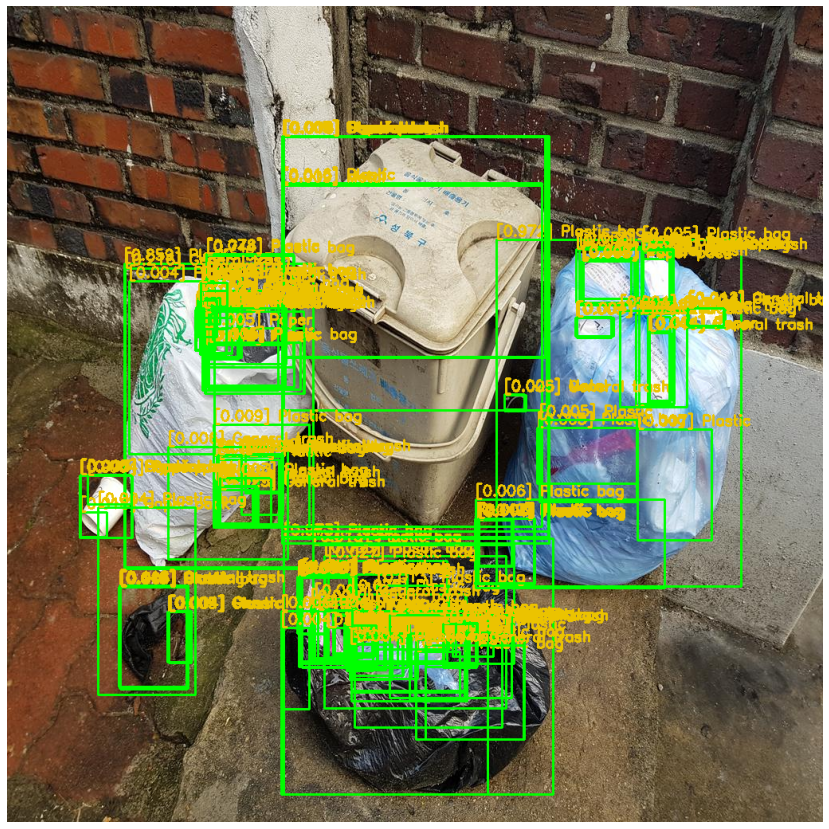

In [15]:
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

img_id = submission.iloc[TEST_IMG_ID]['image_id']
img_arr = cv2.imread(osp.join(DATA_DIR, img_id))
img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

boxes_list = []

total_ensemble_boxes_cnt = 0
total_individual_model_cnt = 0

for df in org_submission_df:
    pred_str = df.iloc[TEST_IMG_ID]['PredictionString']
    pred_bboxes = np.array(pred_str.strip().split()).reshape(-1, 6)
    boxes_list.append(pred_bboxes)

# Visualization for Individual Models
for model_idx, boxes_per_model in enumerate(boxes_list):
    if model_idx not in ENABLE_INDIVIDUAL_MODEL_INDICES:
        continue
    
    for idx, bbox in enumerate(boxes_per_model):
        total_individual_model_cnt += 1
        label, score, xmin, ymin, xmax, ymax = bbox
        xmin, ymin, xmax, ymax = int(float(xmin)), int(float(ymin)), int(float(xmax)), int(float(ymax))

        caption = classes[int(label)] + score

        cv2.rectangle(img_arr, (xmin, ymin), (xmax, ymax), color=individual_model_bbox_colors[model_idx], thickness=2)
        cv2.putText(img_arr, caption, (xmin, ymin-5), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=0.6, color=(253, 241, 115), thickness=1)


# Visualization for Final Ensembled Model
ensemble_boxes = np.array(submission.iloc[TEST_IMG_ID]['PredictionString'].strip().split()).reshape(-1, 6)

if ENABLE_ENSEMBLE:
    for idx, bbox in enumerate(ensemble_boxes):
        total_ensemble_boxes_cnt += 1
        label, score, xmin, ymin, xmax, ymax = bbox
        xmin, ymin, xmax, ymax = int(float(xmin)), int(float(ymin)), int(float(xmax)), int(float(ymax))

        caption = str(f"[{float(score):.3f}]") + " " + str(classes[int(label)])

        cv2.rectangle(img_arr, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=2)
        cv2.putText(img_arr, caption, (xmin, ymin-5), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6, color=ENSEMBLE_BBOX_COLOR_RGB, thickness=2)
 
##
############# Bbox count for Final Ensemble model #################
if ENABLE_ENSEMBLE:
    print("-"*21 + " BBox count for Final Ensemble Model " + "-"*22)
    print("[Final Ensemble]: {}".format(total_ensemble_boxes_cnt))
    print("-"*80)
    print("\n")


############# Bbox count for Selected Individual models #################
if len(ENABLE_INDIVIDUAL_MODEL_INDICES):
    print("-"*18 + " BBox count for Selected Individual Models " + "-"*19)
    print("[Model Indices {}]: {}".format(ENABLE_INDIVIDUAL_MODEL_INDICES, total_individual_model_cnt))
    print("-"*80)
    print("\n")

############# Bbox count for ORIGINAL models #################
print("-"*24 + " BBox count for Original Models " + "-"*24)
org_df_bbox_cnt = [len(np.array(df.iloc[TEST_IMG_ID]['PredictionString'].strip().split()).reshape(-1, 6)) for df in org_submission_df]

for idx, df_fname in enumerate(submission_files):
    model_name = df_fname.split('/')[-1]
    model_bbox_cnt = org_df_bbox_cnt[idx]
    print("[{}]: {}".format(model_name, model_bbox_cnt))

print("")
print("[Total bbox count for ALL original models]: {}".format(sum(org_df_bbox_cnt)))
print("-"*80)

# Plot Predictions
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(img_arr)
print("")

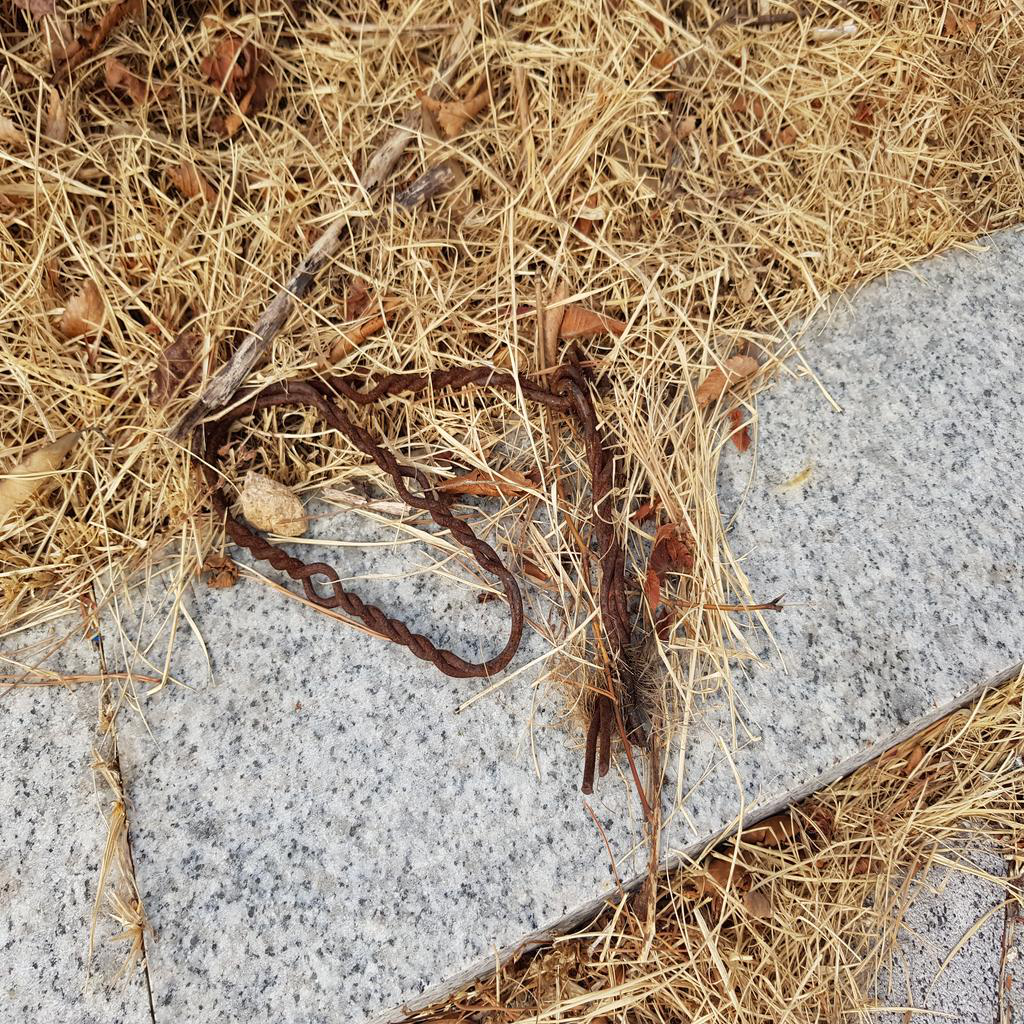

In [16]:
from PIL import Image
Image.open('/opt/ml/detection/dataset/test/1497.jpg')